<a href="https://colab.research.google.com/github/tivon-x/bRAG-langchain/blob/main/notebooks/%5B1%5D_rag_setup_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# bRAG: 检索增强生成（RAG）设置简介

这些笔记本将引导您从零开始构建RAG应用。

它们将帮助您逐步构建对RAG领域的全面理解，如图所示：

![RAG overview](./image/rag-overview.png)


## 安装

安装依赖和创建虚拟环境（可选）

In [ ]:
# 创建虚拟环境
! python -m venv ../venv

In [ ]:
# 激活虚拟环境
! source ../venv/bin/activate

In [ ]:
# 检查python是否在相应的虚拟环境中
! which python

In [ ]:
# 安装依赖
! pip install --quiet python-dotenv langchain langchain-community langchain-core langchain-openai beautifulsoup4 tiktoken numpy langgraph langchain-pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
! pip install --upgrade --quiet  dashscope

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.3 MB/s eta 0:00:00


## Environment

### 1. 环境变量

In [ ]:
# 非colab环境
import os
from dotenv import load_dotenv

# 从 .env 文件加载所有环境变量
load_dotenv()

# LangSmith
langsmith_tracing = os.getenv('LANGSMITH_TRACING')
langsmith_endpoint = os.getenv('LANGSMITH_ENDPOINT')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

## LLM
dashscope_api_key = os.getenv('DASHSCOPE_API_KEY')

## Pinecone 向量数据库
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pinecone_api_host = os.getenv('PINECONE_API_HOST')
index_name = os.getenv('PINECONE_INDEX_NAME')


In [ ]:
# Colab环境
from google.colab import userdata

langsmith_tracing = userdata.get('LANGSMITH_TRACING')
langsmith_endpoint = userdata.get('LANGSMITH_ENDPOINT')
langsmith_api_key = userdata.get('LANGSMITH_API_KEY')

dashscope_api_key = userdata.get("DASHSCOPE_API_KEY")

pinecone_api_key = userdata.get('PINECONE_API_KEY')
pinecone_api_host = userdata.get('PINECONE_API_HOST')
index_name = userdata.get('PINECONE_INDEX_NAME')

### 2. LangSmith
LangSmith用于监控AI应用

https://docs.smith.langchain.com/

In [ ]:
import os
os.environ['LANGSMITH_TRACING'] = langsmith_tracing
os.environ['LANGSMITH_ENDPOINT'] = langsmith_endpoint
os.environ['LANGSMITH_API_KEY'] = langsmith_api_key

### 3. API Keys



In [ ]:
# 使用阿里云百炼平台
os.environ['DASHSCOPE_API_KEY'] = dashscope_api_key

#Pinecone keys
os.environ['PINECONE_API_KEY'] = pinecone_api_key
os.environ['PINECONE_API_HOST'] = pinecone_api_host
os.environ['PINECONE_INDEX_NAME'] = index_name

In [ ]:
# langchain的webbaseloader需要
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"

## Part 1: 代码预览

[RAG quickstart](https://python.langchain.com/docs/tutorials/rag/)

In [ ]:
from pprint import pprint
import bs4

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.embeddings import DashScopeEmbeddings
from langchain_pinecone import PineconeVectorStore


#### 索引 ####

# 加载文档
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# 分块
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# 嵌入、索引
def batch_read(lst, batch_size=10):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

# 向量数据库用来存储嵌入向量和执行相似度搜索
embeddings=DashScopeEmbeddings(model="text-embedding-v4")
vectorstore = PineconeVectorStore(index_name=index_name, embedding=embeddings)

for batch in batch_read(splits):
  vectorstore.add_documents(batch)

retriever = vectorstore.as_retriever()

[RAG chains](https://python.langchain.com/docs/how_to/sequence/)

In [ ]:
#### 检索与生成 ####

##### LangChain #####
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models.tongyi import ChatTongyi

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatTongyi(model="qwen-plus-latest", temperature=0.1)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
# | 是管道运算符，将每一步invoke的结果输入给下一步进行invoke
rag_chain = (
    # 强制转换RunnableParallel，
    # 两个键接收同一个参数并行处理，得到一个字典
    # RunnablePassthrough将接收的数据保持不变传递到下一步骤
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
pprint(rag_chain.invoke("How does LangChain use vector stores for efficient data retrieval?"))

('LangChain uses vector stores to enable long-term memory for agents by '
 'storing and efficiently retrieving large amounts of information. These '
 'vector stores allow fast similarity searches, helping the agent recall '
 "relevant data that isn't in its immediate context. This enhances the model's "
 'ability to work with knowledge beyond its fixed context window.')


[RAG Graph](https://python.langchain.com/docs/tutorials/rag/)

In [ ]:
##### LangGraph #####

from langgraph.graph import START, StateGraph
from typing import List, TypedDict
from langchain_core.documents import Document

# 定义应用的状态
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# 定义应用的检索节点
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

# 定义应用的生成节点
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# 构建图
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [ ]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is the process of breaking down complex tasks into smaller, more manageable steps to improve problem-solving efficiency. It can be performed using methods like Chain of Thought (CoT), Tree of Thoughts, or with external planners like in LLM+P. Techniques include prompting large language models (LLMs) for step-by-step reasoning, task-specific instructions, or incorporating human input.


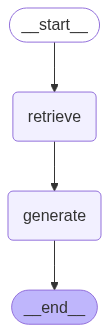

In [ ]:
# 可视化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# 总结：RAG的基本设置
本文档概述了检索增强生成（RAG）应用程序的基本设置。它概述了创建虚拟环境、安装所需软件包以及为API键加载环境变量的必要步骤。

关键组件包括：

- 环境设置：创建虚拟环境和从requirements.txt文件安装依赖项的说明。
- API密钥管理：加载和设置各种服务的环境变量，包括LangChain和Pinecone。
- 文档加载和索引：使用WebBaseLoader从指定的URL加载文档，然后使用RecursiveCharacterTextSplitter将文档拆分为可管理的块。
  - [LangChain的各种文档加载器](https://python.langchain.com/docs/integrations/document_loaders/)
  - [Splitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
  
  ![indexing](./image/indexing.png)

- 嵌入和向量存储：为文档创建嵌入并将其存储在Pinecone向量数据库中，以实现高效检索。
 - [LangChain支持的文本嵌入模型](https://python.langchain.com/docs/integrations/text_embedding/openai)
 - [LangChain支持的向量数据库](https://python.langchain.com/docs/integrations/vectorstores/)
- 检索和生成：通过LangChain和LangGraph分别实现一种检索机制，根据用户查询获取相关文档，并使用语言模型（LLM）生成响应。
  
  ![retrieveNgeneration](./image/retrieveNgeneration.png)

此设置是构建RAG应用程序的基础框架。